# Projet numérique de Science des Données 2025

__Binôme numéro 6 -- MIMOUNI Inès et PRINET Laure__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

__Réponse 1__

Dans ces zones, la difficulté d'accès aux proffessionnel.les de la santé rend l'utilisation de tels algorithmes intéressante : cela permettrait à davantage de femmes de prendre des précautions pour leur grossesse, et aussi de recenser en plus grand nombre ces problématiques et de les transmettre aux autorités de santé locales.

Cependant, l'utilisation exclusive de méthodes algorithmiques entrâine un manque flagrant de contact humain et d'empathie, et de nuance dans le diagnostic: une évaluation de risque n'est jamais binaire et relève toujours du cas par cas, et les solutions à apporter varient aussi en fonction de la femme, de son mode de vie, de ses antécédents...

Si cet algorithme vient à avoir une portée assez large, on ne peut pas savoir si des entreprises pharmaceutiques pourraient l'utiliser avec un seuil de risque plus bas pour vendre leurs produits en faisant peur aux patient.es, et de plus, quel serait le rôle du médecin (qui a fait une dizaine d'années d'études) dans la pratique clinique si l'on accorde une trop grande confiance à des algorithmes de classification ?

## Librairies usuelles

In [1]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [2]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [3]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')
#print(X_train, y_train)

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

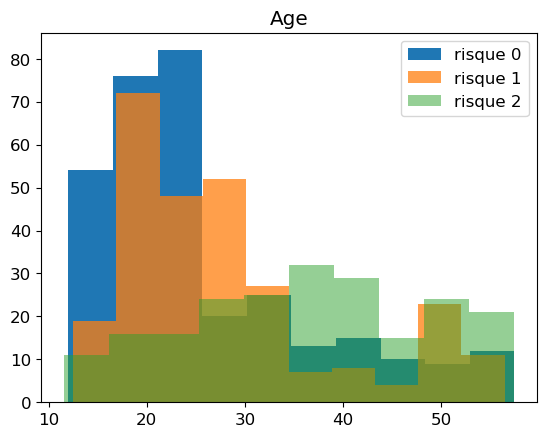

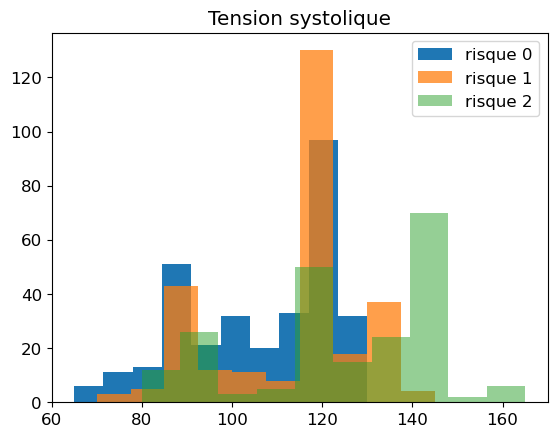

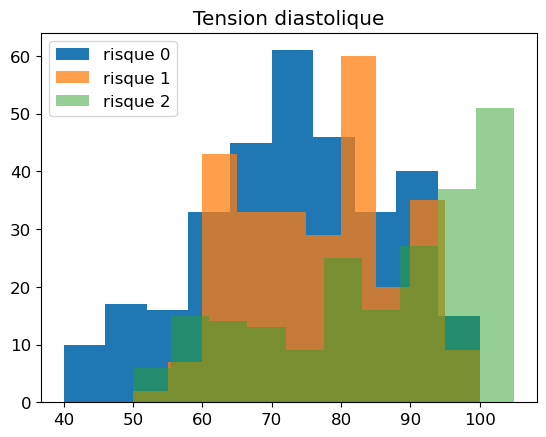

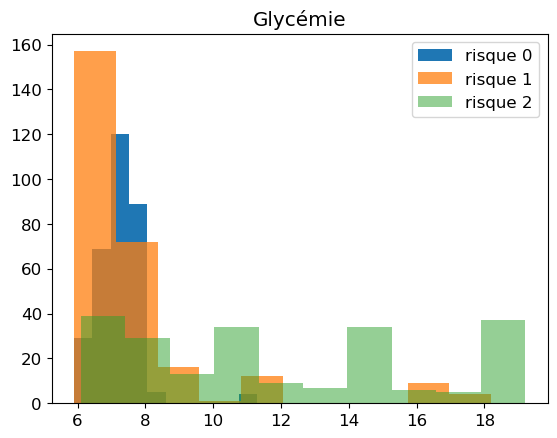

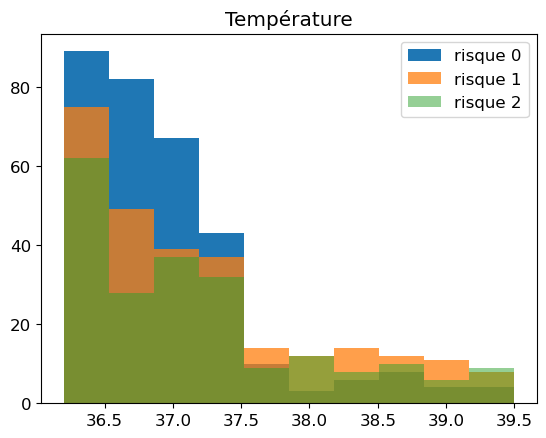

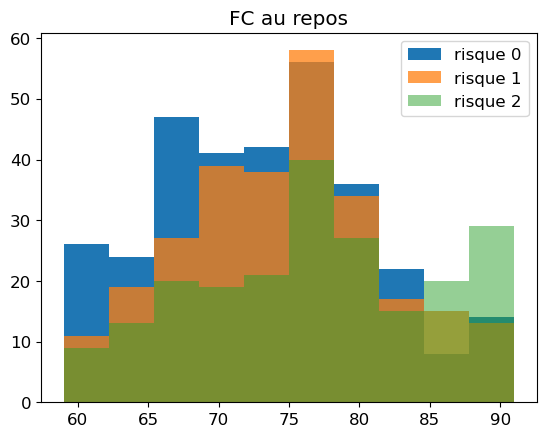

In [4]:

for i in range(6):
    filtered0 = X_train[y_train==0][:,i]
    filtered1 = X_train[y_train==1][:,i]
    filtered2 = X_train[y_train==2][:,i]

    plt.figure()
    plt.title(df_train.columns[i])
    plt.hist(filtered0, label = "risque 0",alpha=1)
    plt.hist(filtered1, label = "risque 1", alpha=0.75)
    plt.hist(filtered2, label = "risque 2",alpha=0.5)
    plt.legend()
    plt.show()



### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

__Réponse 3__

Les valeurs prises par ces variables ne sont pas vraiment surprenantes : l'âge, une tension diastolique et systolyque plus élevées ainsi qu'un taux de glycémie plus élevés sont des signaux d'alarme pour une grossesse à risque. 

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

__Réponse 4__

6 variables suffiront difficilement pour prédire à 100% un risque ou non de grossesse, il faudrait prendre en compte les circonstances individuelles autour de chaque grossesse, et bien plus de critères, notamment qualitatifs (alimentation, mode de vie, changements physiques, douleurs, saignements...).

De plus, certaines données ne semblent pas vraiment indiquer un risque plus ou moins élevé : on remarque que la fréquence cardiaque au repos par exemple, semble difficilement caractériser le risque de grossesse, sauf pour les valeurs fréquence cardiaque extrêmes. De même, la température semble difficilement distinguer les différents groupes.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

Text(0, 0.5, 'PC 2')

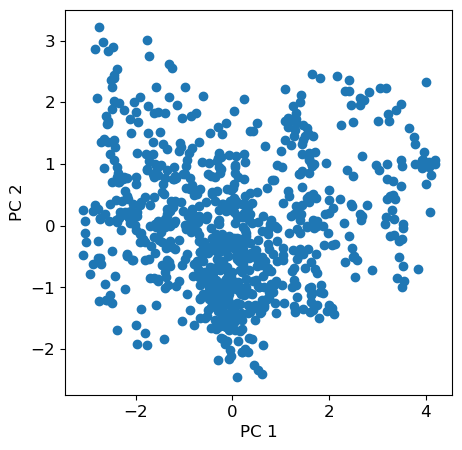

In [5]:
#Pour commencer, on standardise X_train (retirant la moyenne et divisant par l'écart type)
from sklearn import decomposition, preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)

#Maintenant, on veut qu'il n'y ait plus que les deux premières composantes principales (PC1 et PC2) pour pouvoir voir les données en 2D:
pca = decomposition.PCA(n_components=2) #Instanciation d'un objet PCA des 2 composantes principales
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

#Visualisation : 
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_projected[:, 0], X_projected[:, 1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")


### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

__Réponse 6__

Les points étant vraiment dispersés, il n'apparaît pas de tendance particulière. Ainsi, cette ACP ne semble pas utile pour construire un prédicteur de risque de grossesse difficile.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [6]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

__Réponse 15__
La séparation d'un jeu de données en un jeu de test et un jeu d'entraînement est nécessairement arbitraire. Ainsi, notre grille de valeurs va ici être séparée en 10 "paquets" et ce dix fois, avec un mélange aléatoire. Le but étant qu'à chaque fois, un des paquets correspondent au jeu de test pour les 9 paquets restants formant le jeu d'entraînement. Nous moyennons enfin sur ces dix fois pour moyenner les effets aléatoires.

In [ ]:
from sklearn import model_selection

# Créer un objet KFold avec 10folds
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

from sklearn import linear_model, metrics
lasso=linear_model.Lasso(alpha=0.01,random_state=13)

lasso_cv_scores = model_selection.cross_val_score(lasso, X_train, y_train, 
                                                  cv=kf, # utiliser les folds déjà définis 
                                                  scoring='neg_root_mean_squared_error')
print(lasso_cv_scores) # Liste des 10 rmse (avec un moins devant car "neg"_root_mean_squared_error)
print(f"La RMSE moyenne du Lasso (alpha=0.01) est de {-np.mean(lasso_cv_scores):.2f}")

	RMSE (test) : 0.60
	RMSE (test) : 0.62
	RMSE (test) : 0.65
	RMSE (test) : 0.70
	RMSE (test) : 0.65
	RMSE (test) : 0.66
	RMSE (test) : 0.63
	RMSE (test) : 0.53
	RMSE (test) : 0.63
	RMSE (test) : 0.60
La RMSE moyenne du Lasso (alpha=0.01) est de 0.63


On voit bien la répartition entre les données pour le test et pour le training!

In [12]:
# Définir la grille de valeurs de l'hyperparamètre alpha 
alphas = np.logspace(-5, 1, 40)

# Définir le modèle à évaluer
lasso = linear_model.Lasso(random_state=13, 
                           max_iter=10000 # pour assurer la convergence (warning sinon)
                          )

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(lasso, {'alpha': alphas}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='neg_root_mean_squared_error'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train, y_train)

grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

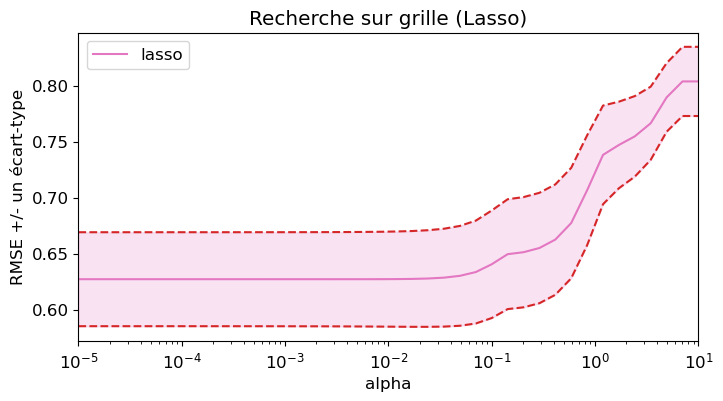

In [20]:
# Illustration par un graphique de l'exploration de la grille
plt.figure(figsize=(8, 4))

rmses = -grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.semilogx(grid.cv_results_['param_alpha'], rmses, 
             label="lasso", color='tab:pink')
plt.semilogx(grid.cv_results_['param_alpha'], rmses + std_error, 
             color='tab:red', linestyle='dashed')
plt.semilogx(grid.cv_results_['param_alpha'], rmses - std_error, 
             color='tab:red', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(alphas, (rmses + std_error), (rmses - std_error), 
                 color='tab:pink',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("alpha")
plt.ylabel("RMSE +/- un écart-type")
plt.xlim([alphas[0], alphas[-1]])
plt.title("Recherche sur grille (Lasso)")
plt.legend(loc='best')

Commentaire du graphique : 
**A REMPLIR**

In [14]:
# Valeur optimale de l'hyperparamètre
print(f"La meilleure valeur de alpha est : {grid.best_params_['alpha']:.2e}")

La meilleure valeur de alpha est : 2.89e-03


La précision équilibrée est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

In [ ]:
from sklearn.metrics import balanced_accuracy_score
# y_pred?
# y_true?
# balanced_accuracy_score(y_true, y_pred)
# print (f'la précision équilibrée associée à la meilleure valeur de alpha est : {x}')

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [24]:
# Créer un objet KFold avec 10folds
kf2 = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# On fait maintenatn une régression logistique
lasso2=linear_model.LogisticRegression(penalty='none',solver='newton-cg', max_iter=10000)
lasso_cv_scores2 = model_selection.cross_val_score(lasso2, X_train, y_train, 
                                                  cv=kf2, # utiliser les folds déjà définis 
                                                  scoring='neg_root_mean_squared_error')
print(lasso_cv_scores2) # Liste des 10 rmse (avec un moins devant car "neg"_root_mean_squared_error)
print(f"La RMSE moyenne du Lasso (alpha=0.01) est de {-np.mean(lasso_cv_scores):.2f}")

# Définir la grille de valeurs de l'hyperparamètre alpha 
alphas = np.logspace(-5, 1, 40)

# Instantier la recherche sur grille
grid2 = model_selection.GridSearchCV(lasso2, {'alpha': alphas}, 
                                    cv=kf2, # on utilise les folds déjà définis
                                    scoring='neg_root_mean_squared_error'
                                   )

# Utiliser la recherche sur grille
grid2.fit(X_train, y_train)

# Illustration par un graphique de l'exploration de la grille
plt.figure(figsize=(8, 4))

rmses2 = -grid2.cv_results_['mean_test_score']
std_error2 = grid2.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.semilogx(grid2.cv_results_['param_alpha'], rmses2, 
             label="lasso", color='tab:pink')
plt.semilogx(grid2.cv_results_['param_alpha'], rmses2 + std_error2, 
             color='tab:red', linestyle='dashed')
plt.semilogx(grid2.cv_results_['param_alpha'], rmses2 - std_error2, 
             color='tab:red', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(alphas, (rmses2 + std_error2), (rmses2 - std_error2), 
                 color='tab:pink',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("alpha")
plt.ylabel("RMSE +/- un écart-type")
plt.xlim([alphas[0], alphas[-1]])
plt.title("Recherche sur grille (Lasso)")
plt.legend(loc='best')

# Valeur optimale de l'hyperparamètre
print(f"La meilleure valeur de alpha est : {grid2.best_params_['alpha']:.2e}")

[-0.61237244 -0.66143783 -0.76648549 -0.83666003 -0.79843597 -0.76648549
 -0.67082039 -0.68920244 -0.68007353 -0.68920244]
La RMSE moyenne du Lasso (alpha=0.01) est de nan


ValueError: Invalid parameter alpha for estimator LogisticRegression(max_iter=10000, penalty='none', solver='newton-cg'). Check the list of available parameters with `estimator.get_params().keys()`.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.